# Using PyTorch Lightning and MLFlow with Rockpool

## Set up task

In [1]:
from torch.utils.data import DataLoader
import torch
import numpy as np

from rockpool import TSEvent
from rockpool.parameters import Constant

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

from dataclasses import dataclass, field

In [2]:
import torch

# - Define a dataset class implementing the indexing interface
class MultiClassRandomSinMapping:
    def __init__(self,
                 num_classes: int = 2,
                 sample_length: int = 100,
                 input_channels: int = 50,
                 target_channels: int = 2):
        # - Record task parameters
        self._num_classes = num_classes
        self._sample_length = sample_length
        
        # - Draw random input signals
        self._inputs = np.random.randn(num_classes, sample_length, input_channels) + 1.
        
        # - Draw random sinusoidal target parameters
        self._target_phase = np.random.rand(num_classes, 1, target_channels) * 2 * np.pi
        self._target_omega = np.random.rand(num_classes, 1, target_channels) * sample_length / 50
        
        # - Generate target output signals
        time_base = np.atleast_2d(np.arange(sample_length) / sample_length).T
        self._targets = np.sin(2 * np.pi * self._target_omega * time_base + self._target_phase)
    
    def __len__(self):
        # - Return the total size of this dataset
        return self._num_classes
    
    def __getitem__(self, i):
        # - Return the indexed dataset sample
        return torch.Tensor(self._inputs[i]), torch.Tensor(self._targets[i])

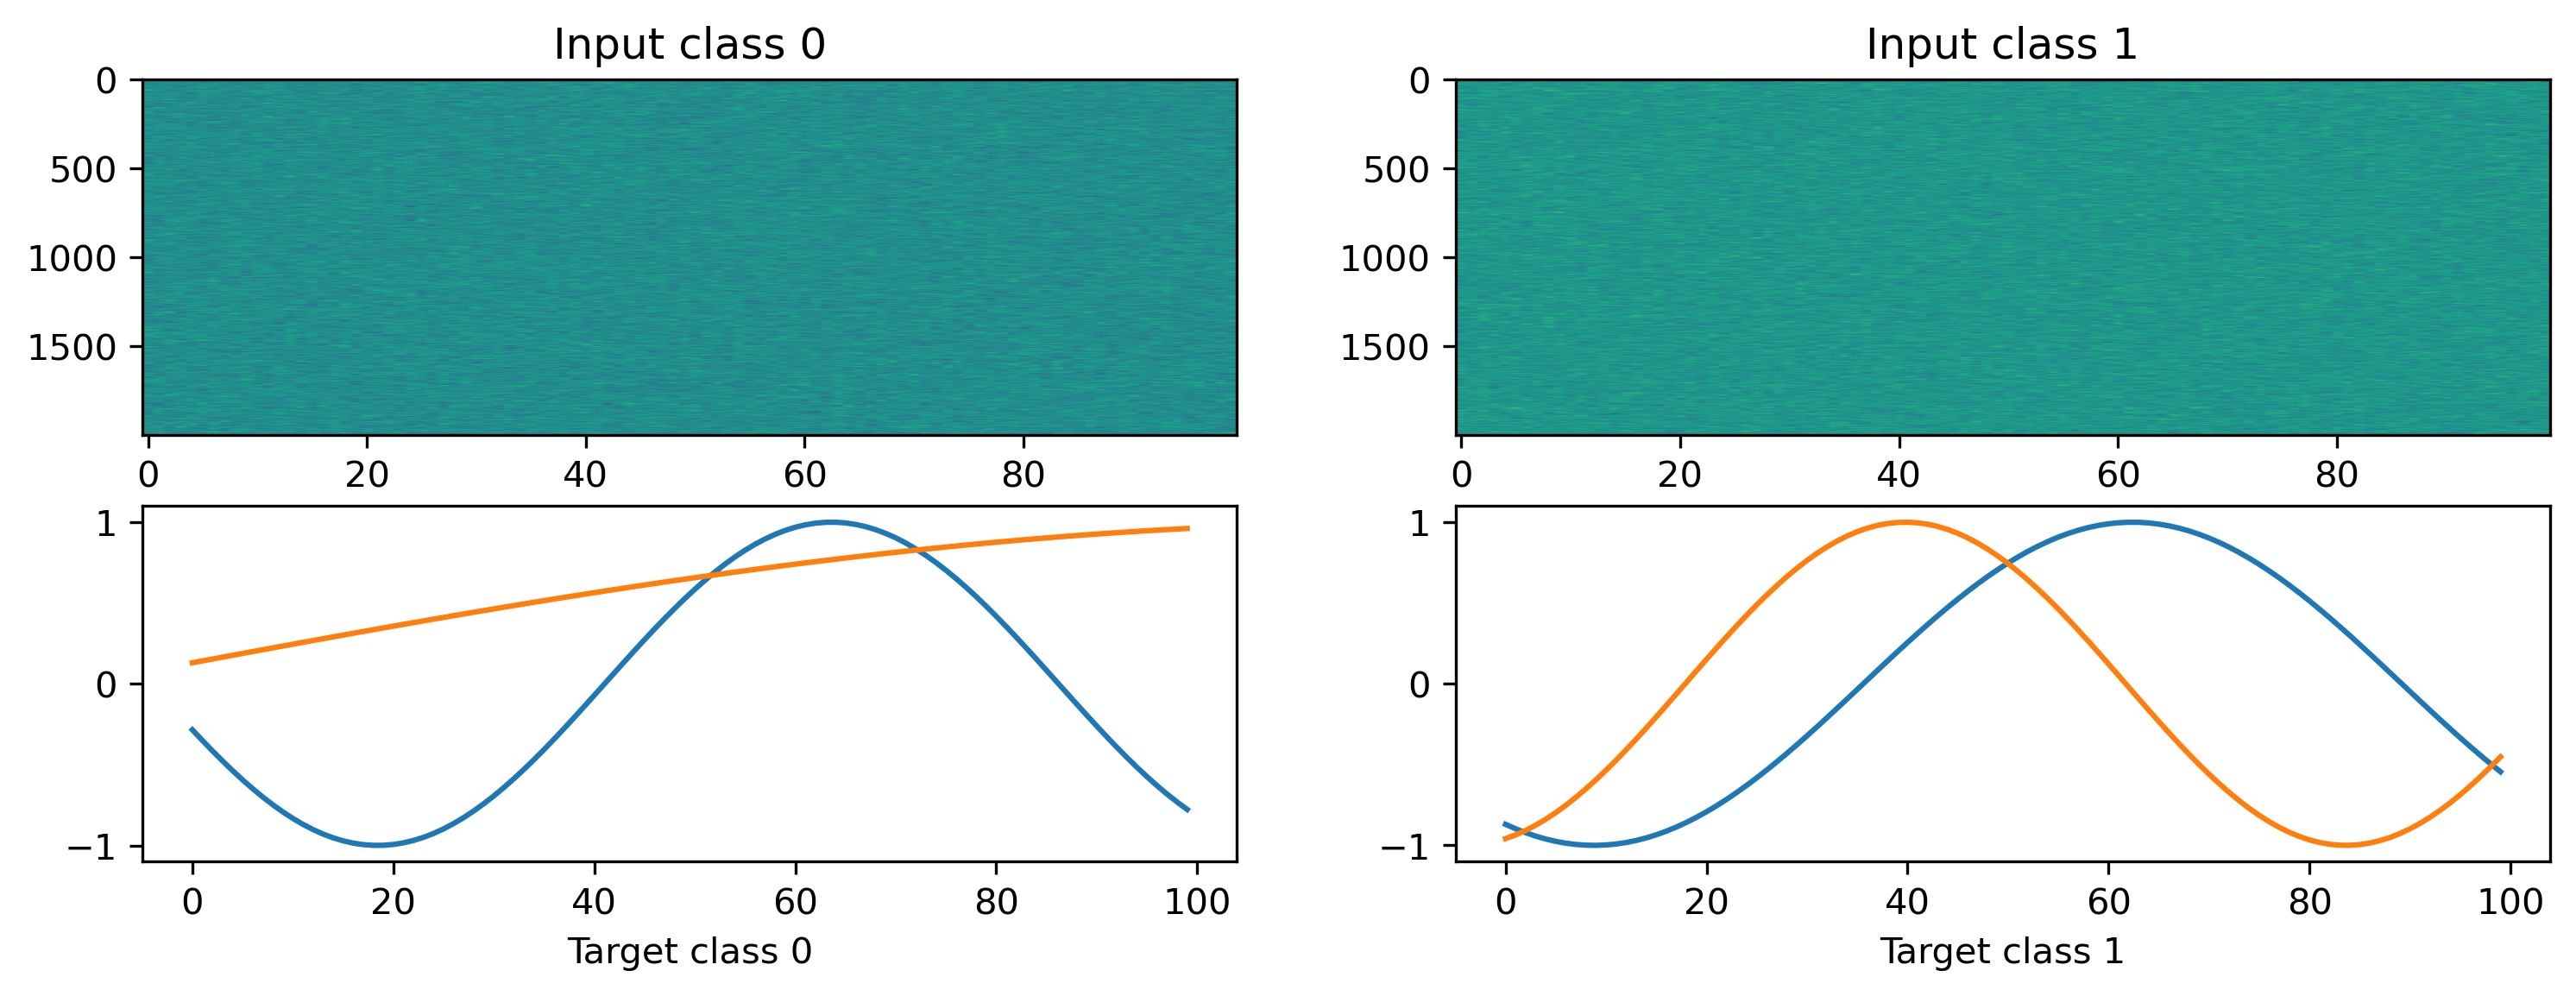

In [3]:
# - Instantiate a dataset
Nin = 2000
Nout = 2
num_classes = 2
T = 100
ds = MultiClassRandomSinMapping(num_classes = num_classes,
                                input_channels = Nin,
                                target_channels = Nout,
                                sample_length = T,
                               )

# Display the dataset classes
plt.figure()
for i, sample in enumerate(ds):
    plt.subplot(2, len(ds), i + 1)
    plt.imshow(sample[0].T, aspect='auto')
    plt.title(f'Input class {i}')
    
    plt.subplot(2, len(ds), i + len(ds) + 1)
    plt.plot(sample[1])
    plt.xlabel(f'Target class {i}')

In [4]:
dl_train = DataLoader(
    ds,
    num_workers = 0,
    batch_size = 64)

## Define network and model

In [5]:
from rockpool.nn.modules import LIFTorch, LinearTorch, RateTorch, InstantTorch
from rockpool.nn.combinators import Sequential, Residual

from torch.nn import functional as F

import pytorch_lightning as pl

import mlflow

/Users/dylanaictx/SynSense Dropbox/Dylan Muir/LiveSync/Development/rockpool_GIT/rockpool/nn/modules/__init__.py:45: UserWarning: Sinabs modules not available: 'Slayer' backend not found. Modules that rely on Sinabs-Slayer will not be available.
  warnings.warn(f"Sinabs modules not available: {err}")
/Users/dylanaictx/SynSense Dropbox/Dylan Muir/LiveSync/Development/rockpool_GIT/rockpool/utilities/__init__.py:22: UserWarning: Could not import modules: 'Brian2' backend not found. Modules that rely on Brian will not be available.
  warnings.warn(f"Could not import modules: {err}")


Could not import package: 'Brian2'backend not found. Modules that rely on Brian will not be available.
Could not import package: No module named 'iaf_nest'


/Users/dylanaictx/SynSense Dropbox/Dylan Muir/LiveSync/Development/rockpool_GIT/rockpool/nn/modules/__init__.py:63: UserWarning: NEST modules not available: 'NEST' backend not found. Modules that rely on NEST will not be available.
  warnings.warn(f"NEST modules not available: {err}")


In [6]:
Nhidden = 10
dt_snn = 1e-3

In [7]:
# - Define a PyTorch Lightning module
class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = Sequential(
            LinearTorch((Nin, Nhidden)),
            InstantTorch(Nhidden, torch.tanh),
            LinearTorch((Nhidden, Nout)),
        ).to_torch()
        
        self._last_loss = torch.inf
    
    def forward(self, x):
        return self.net(x)
    
    def _shared_eval_step(self, batch):
        x, y = batch
        y_hat = self(x)
#         y = y.unsqueeze(1).repeat(1, y_hat.shape[1])
        
        crit = ((y_hat - y) ** 2).sum()
        reg = torch.sum(y_hat == 0)
        loss = crit + reg

        self._last_loss = loss
        
        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self._shared_eval_step(batch)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._shared_eval_step(batch)
        self.log("val_loss", loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [8]:
# - Instantiate the model
model = Model()

In [9]:
# - Initialize a trainer
trainer = pl.Trainer(
    callbacks = [pl.callbacks.ModelCheckpoint()],
    max_epochs=1000,
)

# - Enable autologging
mlflow.pytorch.autolog()

# - Create a new MLFlow run and fit the model
with mlflow.start_run() as run:
    trainer.fit(model, dl_train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
2022/02/02 17:26:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
2022/02/02 17:26:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/wavesense/lib/python3.8/site-packages/pytorch_lightning/core/memory.py:16: LightningDeprecationWarning: `pytorch_lightning.core.memory.get_memory_profile` and `pytorch_lightning.core.memory.get_gpu_memory_map` have been moved to `pytorch_lightning.utilities.memory` since v1.5 and will be removed in v1.7."
2022/02/02 17:26:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/wavesense/lib/python3.8/site-packages/pytorch_lightning/core/memory.py:25: LightningDeprecationWar

Training: 0it [00:00, ?it/s]

In [25]:
sample, target = ds[0]

In [26]:
model(sample).shape

torch.Size([1, 100, 2])

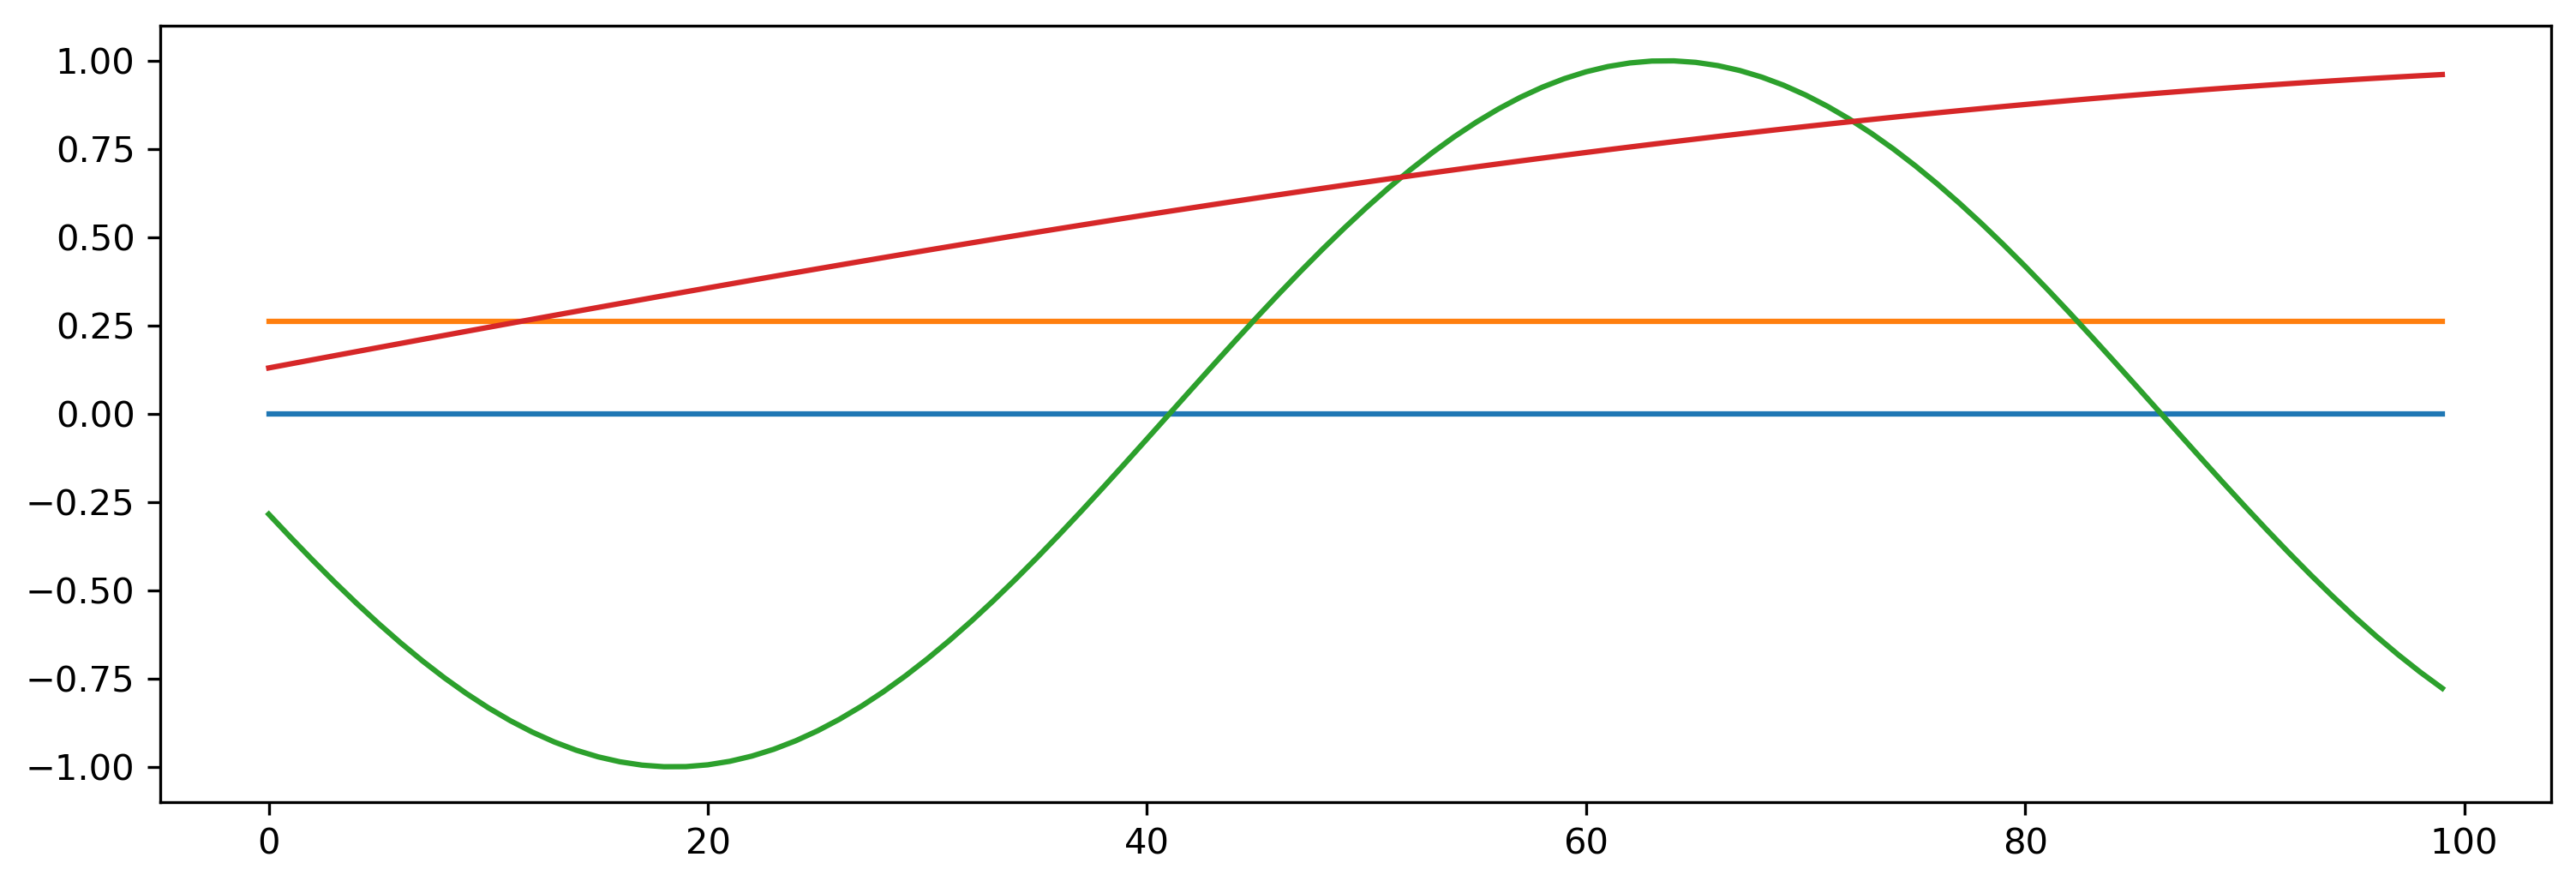

In [27]:
plt.plot(model(sample).detach().numpy().squeeze());
plt.plot(target.numpy());

In [12]:
out, _, r_d = model.net.evolve(sample, record = True)

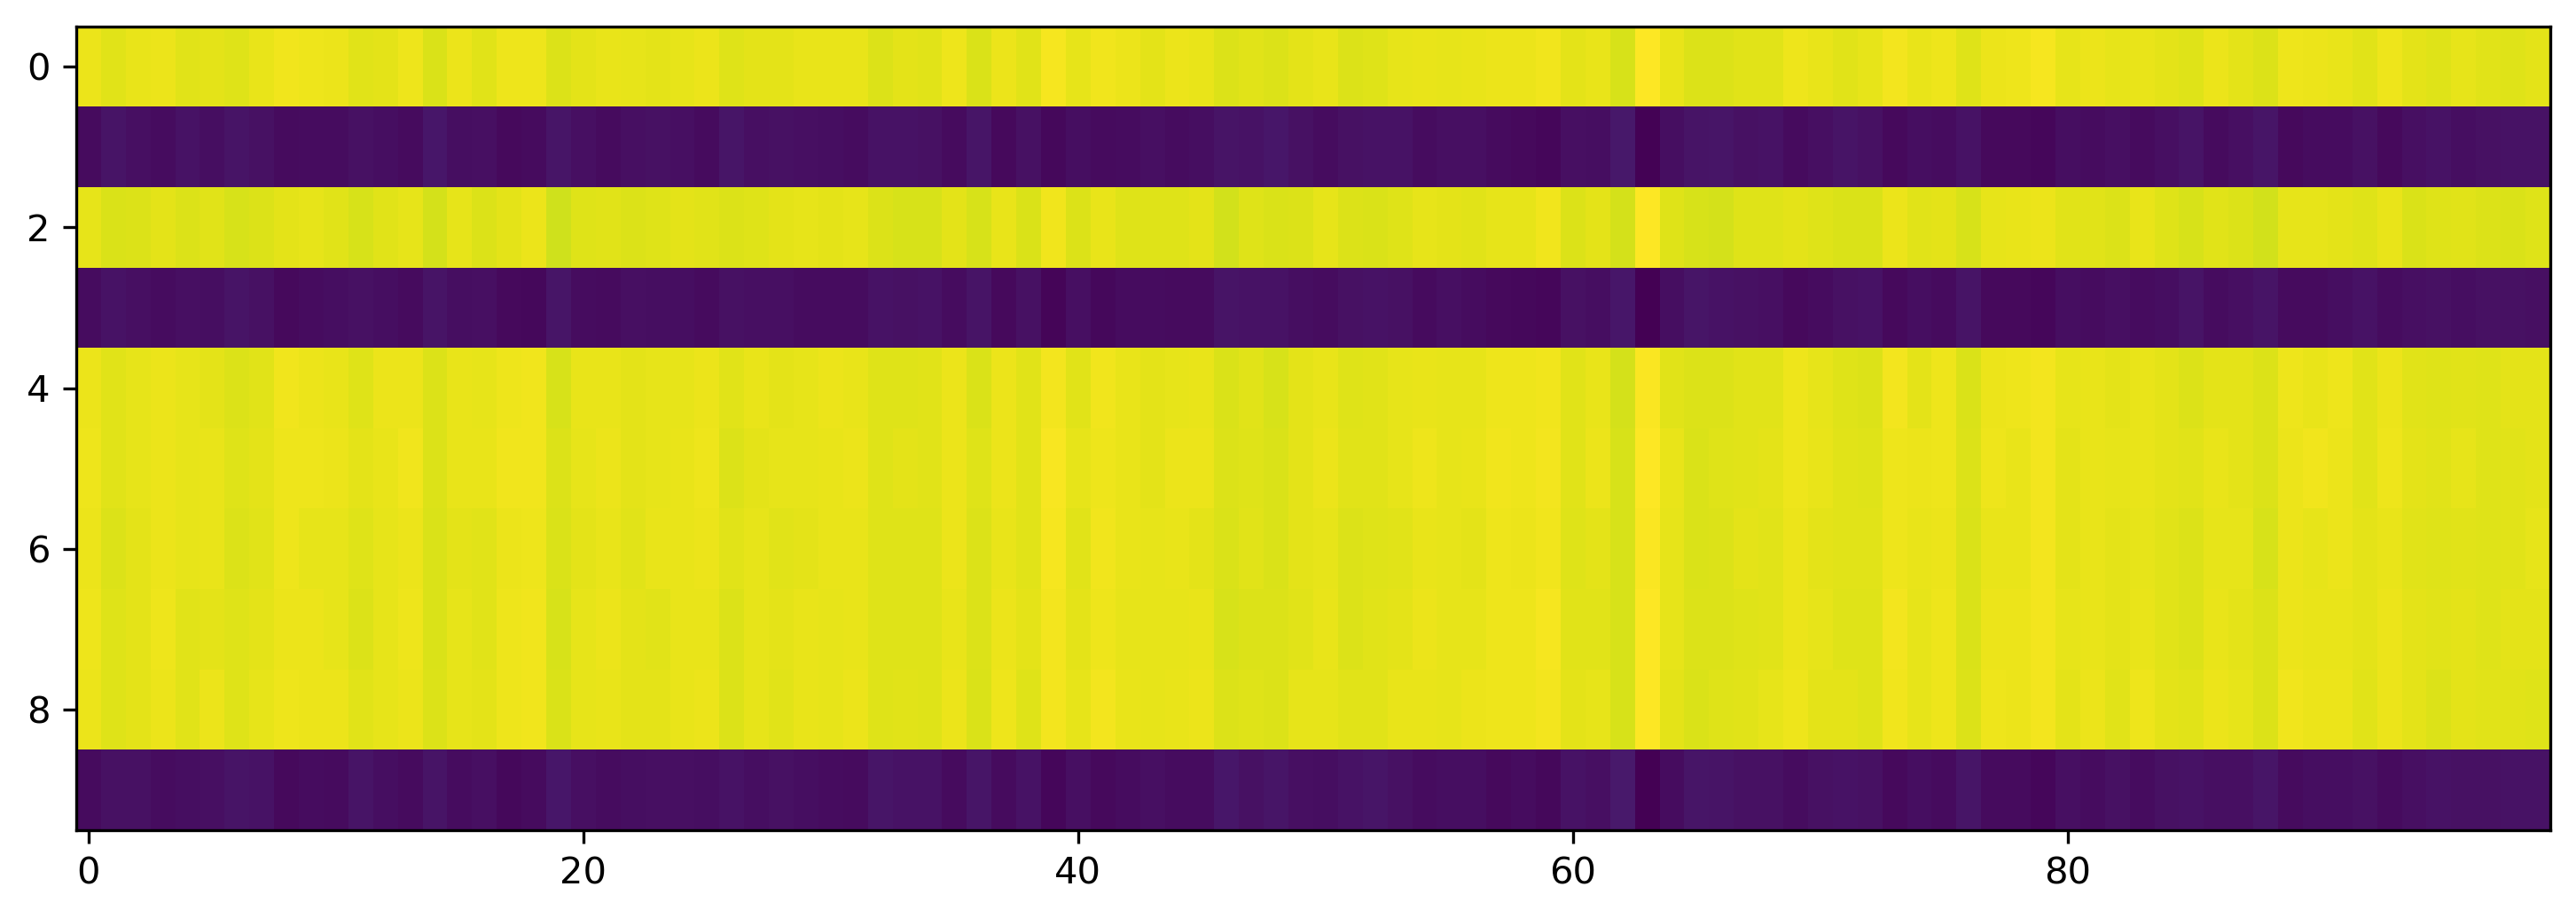

In [13]:
plt.imshow(r_d['0_LinearTorch_output'].squeeze().detach().numpy().T, aspect = 'auto')

In [14]:
plt.imshow(r_d['1_LIFTorch']['vmem'].detach().numpy().squeeze().T, aspect='auto')

KeyError: '1_LIFTorch'

In [ ]:
plt.imshow(r_d['1_LIFTorch_output'].squeeze().detach().numpy().T, aspect = 'auto')

In [ ]:
plt.imshow(r_d['3_LIFTorch_output'].squeeze().detach().numpy().T, aspect = 'auto')